# Week 8
## Overview

It's the last time we meet in class for exercises! And to celebrate this mile-stone, I've put together an very nice little set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - That's it!


# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



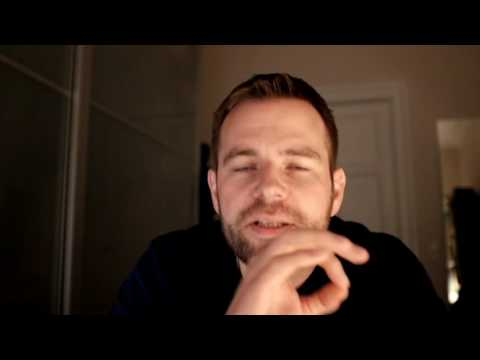

In [57]:
from IPython.display import YouTubeVideo
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

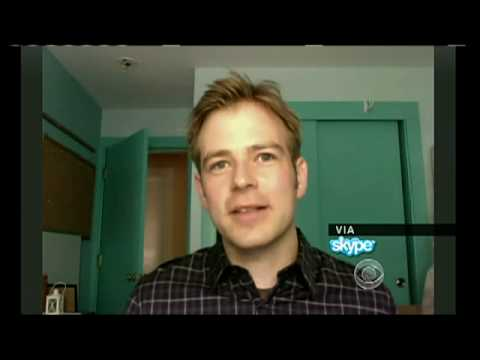

In [58]:
# There's also this one from 2010 with young Sune's research
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
>   * The LabMT wordlist was genererad combining words most frequently appearing in four sources: Twitter, The NY Times, Google Books and music lyrics. A scoring about thier sentiment for each each word was then given.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?

<div class="alert alert-block alert-info">
As long as you get the plots right, it's OK to use LLM help here.
</div>

In [59]:
import pandas as pd
import requests
import networkx as nx
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pickle as pkl

In [60]:
url = "https://raw.githubusercontent.com/Jacopo00811/socialgraphs2025/refs/heads/main/graphs/rock_performers_network.graphml"

try:
    response = requests.get(url)
    response.raise_for_status()
    G = nx.parse_graphml(response.text)

    print("Successfully loaded the graph from GitHub.")
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
except requests.exceptions.RequestException as e:
    print(f"Failed to download the graph fil    e: {e}")

G_undirected = G.to_undirected()

Successfully loaded the graph from GitHub.
Graph has 487 nodes and 7370 edges.


In [61]:
df = pd.read_csv('..\\files\\LabMTWordList.txt', sep='\t', skiprows=2)
wordlist = df.set_index('word')['happiness_average'].to_dict()

def sentiment_score(tokens, wordlist):
    score = 0
    tokens = [token.lower() for token in tokens]
    token_counts = len(tokens)
    for token in tokens:
        if token in wordlist:
            score += wordlist[token]
    return score / token_counts if token_counts > 0 else 0

tokens = ['happy', 'joy', 'sad', 'angry']
print(sentiment_score(tokens, wordlist))

5.29


In [62]:
def get_wikipedia_page(artist_name):
    """Fetch Wikipedia page for an artist."""
    # Format the artist name for URL
    formatted_name = artist_name.replace(" ", "_")
    url = f"https://en.wikipedia.org/wiki/{formatted_name}"
    
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Jupyter Notebook) Educational project/1.0'}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.text
        else:
            # Try with "band" or "musician" appended if not found
            url = f"https://en.wikipedia.org/wiki/{formatted_name}_(band)"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text
            
            url = f"https://en.wikipedia.org/wiki/{formatted_name}_(musician)"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text
            
            return None
    except Exception as e:
        print(f"Error fetching page for {artist_name}: {e}")
        return None
    
def tokenize_text(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    for script in soup(["script", "style"]):
        script.decompose()
    
    text = soup.get_text()
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return tokens

if not "rock_performers_with_sentiment.graphml" in os.listdir("..\\graphs"):
    print("Fetching Wikipedia pages and calculating sentiment...")
    sentiments = {}
    failed_artists = []
    for i, artist in enumerate(G_undirected.nodes()):
        print(f"Processing {i+1}/{G_undirected.number_of_nodes()}: {artist}")
        page_content = get_wikipedia_page(artist)
        if page_content:
            tokens = tokenize_text(page_content)
            sentiment = sentiment_score(tokens, wordlist)
            G_undirected.nodes[artist]['sentiment'] = sentiment
            sentiments[artist] = sentiment
            print(f"✓ Sentiment: {sentiment:.4f}")
        else:
            print(f"✗ Failed to fetch page")
            failed_artists.append(artist)
            G_undirected.nodes[artist]['sentiment'] = None
        
        # small delay
        time.sleep(0.3)

else:
    print("Graph with sentiments already exists. Loading from file...")
    G_undirected = nx.read_graphml("..\\graphs\\rock_performers_with_sentiment.graphml")

sentiments = {node: data['sentiment'] for node, data in G_undirected.nodes(data=True) if data['sentiment'] is not None}
print(f"\nCompleted! Successfully processed {len(sentiments)} artists.")

# calculate statistics
sentiment_values = list(sentiments.values())
mean_sentiment = np.mean(sentiment_values)
median_sentiment = np.median(sentiment_values)
variance_sentiment = np.var(sentiment_values)
percentile_25 = np.percentile(sentiment_values, 25)
percentile_75 = np.percentile(sentiment_values, 75)

print("\n" + "="*50)
print("SENTIMENT STATISTICS")
print("="*50)
print(f"Mean:          {mean_sentiment:.4f}")
print(f"Median:        {median_sentiment:.4f}")
print(f"Variance:      {variance_sentiment:.4f}")
print(f"Std Dev:       {np.std(sentiment_values):.4f}")
print(f"25th percentile: {percentile_25:.4f}")
print(f"75th percentile: {percentile_75:.4f}")
print(f"Min:           {min(sentiment_values):.4f}")
print(f"Max:           {max(sentiment_values):.4f}")

Graph with sentiments already exists. Loading from file...

Completed! Successfully processed 487 artists.

SENTIMENT STATISTICS
Mean:          4.6100
Median:        4.6185
Variance:      0.0179
Std Dev:       0.1339
25th percentile: 4.5209
75th percentile: 4.7003
Min:           4.0050
Max:           4.9520


In [63]:
# save graph with sentiments
nx.write_graphml(G_undirected, "..\\graphs\\rock_performers_with_sentiment.graphml")

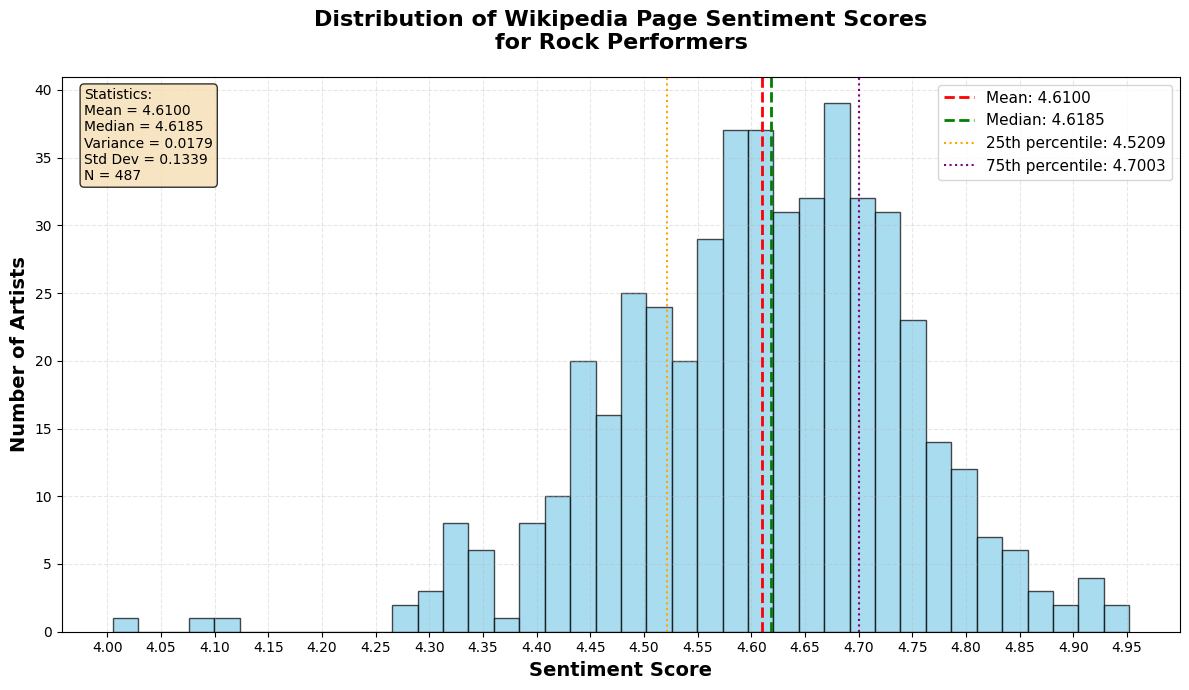


TOP 10 HAPPIEST ARTISTS (highest sentiment)
 1. Blue October                             4.9520
 2. Dallas Green (musician)                  4.9303
 3. Train (band)                             4.9280
 4. The Beach Boys                           4.9278
 5. Boys Like Girls                          4.9242
 6. The Script                               4.9067
 7. Black Stone Cherry                       4.8928
 8. Bowling for Soup                         4.8870
 9. Alter Bridge                             4.8630
10. Simple Plan                              4.8583

TOP 10 SADDEST ARTISTS (lowest sentiment)
 1. Volbeat                                  4.3178
 2. Sepultura                                4.3157
 3. Catfish and the Bottlemen                4.3124
 4. Nirvana (band)                           4.3042
 5. Ritchie Valens                           4.2936
 6. Golden Earring                           4.2767
 7. Parliament (band)                        4.2738
 8. Tracy Chapman           

In [64]:
# plot
fig, ax = plt.subplots(figsize=(12, 7))
n, bins, patches = ax.hist(sentiment_values, bins=40, 
                           color='skyblue', edgecolor='black', 
                           alpha=0.7)
ax.axvline(mean_sentiment, color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {mean_sentiment:.4f}')
ax.axvline(median_sentiment, color='green', linestyle='--', 
           linewidth=2, label=f'Median: {median_sentiment:.4f}')
ax.axvline(percentile_25, color='orange', linestyle=':', 
           linewidth=1.5, label=f'25th percentile: {percentile_25:.4f}')
ax.axvline(percentile_75, color='purple', linestyle=':', 
           linewidth=1.5, label=f'75th percentile: {percentile_75:.4f}')
ax.set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Artists', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Wikipedia Page Sentiment Scores\nfor Rock Performers', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(np.arange(4, 5, 0.05))
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
textstr = f'Statistics:\n' \
          f'Mean = {mean_sentiment:.4f}\n' \
          f'Median = {median_sentiment:.4f}\n' \
          f'Variance = {variance_sentiment:.4f}\n' \
          f'Std Dev = {np.std(sentiment_values):.4f}\n' \
          f'N = {len(sentiment_values)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

# top 10 happiest and saddest artists
sorted_by_sentiment = sorted(sentiments.items(), key=lambda x: x[1], reverse=True)

print("\n" + "="*50)
print("TOP 10 HAPPIEST ARTISTS (highest sentiment)")
print("="*50)
for i, (artist, score) in enumerate(sorted_by_sentiment[:10], 1):
    print(f"{i:2d}. {artist:40s} {score:.4f}")

print("\n" + "="*50)
print("TOP 10 SADDEST ARTISTS (lowest sentiment)")
print("="*50)
for i, (artist, score) in enumerate(sorted_by_sentiment[-10:], 1):
    print(f"{i:2d}. {artist:40s} {score:.4f}")


*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
>   - What are the three happiest communities? 
>   - What are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
>       * It's hard to answer, generally all the words in the wordclouds are major artist in a band or big artist in a specific genre. The division in community is not clear and could indicate collaboration / work relationships with the artists named in the wordclouds. The sentiment is pretty much the same for all the communities so does not give much information with the small variation found 4.53 to 4.6 approximately.
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?
>   * The sentiment is indeed similar ranging from 4.53 to 4.6 and being right in the mean / median range highlighted by the previous exercise and it's quite similar across the communities. 
<div class="alert alert-block alert-info">
As above, feel free to go nuts with help from an LLM with this exercise for the technical parts. But try to answer the questions about interpreting the results with your own human brain.
</div>

**Note**: Calculating sentiment may take a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

In [ ]:
louvian_communities = pkl.load(open('..\\graphs\\louvian_communities.pkl', 'rb'))
sorted_communities = sorted(louvian_communities, key=len, reverse=True)
top_5_communities = sorted_communities[:5]
community_sentiments = []

print("="*80)
print("ANALYZING SENTIMENT FOR THE 5 LARGEST COMMUNITIES")
print("="*80)

for i, community in enumerate(top_5_communities):
    sentiments_in_comm = [G_undirected.nodes[node]['sentiment'] for node in community if G_undirected.nodes[node].get('sentiment') is not None]
    
    if not sentiments_in_comm:
        avg_sentiment = 0
    else:
        avg_sentiment = np.mean(sentiments_in_comm)
        
    # find names for the community
    community_subgraph = G_undirected.subgraph(community)
    degrees_in_comm = dict(community_subgraph.degree())
    # sort by the most connected
    sorted_nodes = sorted(degrees_in_comm.items(), key=lambda item: item[1], reverse=True)
    top_3_artists = [artist for artist, _ in sorted_nodes[:3]]
    community_name = ", ".join(top_3_artists)
    
    community_sentiments.append({
        'id': i,
        'name': community_name,
        'size': len(community),
        'avg_sentiment': avg_sentiment
    })
    
    print(f"Community {i} (Size: {len(community)}):")
    print(f"  Name: {community_name}")
    print(f"  Average Sentiment: {avg_sentiment:.4f}\n")

# identify happiest and saddest communities
sorted_by_sentiment = sorted(community_sentiments, key=lambda x: x['avg_sentiment'], reverse=True)

print("\n" + "="*80)
print("HAPPIEST AND SADDEST COMMUNITIES")
print("="*80)

print("\nTop 3 Happiest Communities:")
for comm in sorted_by_sentiment[:3]:
    print(f"  ID: {comm['id']}, Sentiment: {comm['avg_sentiment']:.4f}, Name: {comm['name']}")

print("\nTop 3 Saddest Communities:")
for comm in sorted_by_sentiment[-3:]:
    print(f"  ID: {comm['id']}, Sentiment: {comm['avg_sentiment']:.4f}, Name: {comm['name']}")

ANALYZING SENTIMENT FOR THE 5 LARGEST COMMUNITIES
Community 0 (Size: 162):
  Name: Bob Dylan, Eric Clapton, Paul McCartney
  Average Sentiment: 4.6016

Community 1 (Size: 133):
  Name: David Bowie, Green Day, U2
  Average Sentiment: 4.6267

Community 2 (Size: 118):
  Name: Metallica, Black Sabbath, Deep Purple
  Average Sentiment: 4.5918

Community 3 (Size: 63):
  Name: Alice in Chains, Breaking Benjamin, Shinedown
  Average Sentiment: 4.6526

Community 4 (Size: 7):
  Name: Lynyrd Skynyrd, Charlie Daniels, The Marshall Tucker Band
  Average Sentiment: 4.5323


HAPPIEST AND SADDEST COMMUNITIES

Top 3 Happiest Communities:
  ID: 3, Sentiment: 4.6526, Name: Alice in Chains, Breaking Benjamin, Shinedown
  ID: 1, Sentiment: 4.6267, Name: David Bowie, Green Day, U2
  ID: 0, Sentiment: 4.6016, Name: Bob Dylan, Eric Clapton, Paul McCartney

Top 3 Saddest Communities:
  ID: 0, Sentiment: 4.6016, Name: Bob Dylan, Eric Clapton, Paul McCartney
  ID: 2, Sentiment: 4.5918, Name: Metallica, Black Sab